In [124]:
import os
import sys
sys.path.append('../')
import numpy as np
import scipy.io as scio
import h5py
from numpy.fft import fft, ifft, fft2, ifft2, fftshift, ifftshift
import numba
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tempfile import gettempdir
from kwave.ksource import kSource
from kwave.kspaceFirstOrder2D import kspaceFirstOrder2DC
from kwave.utils import *
from kwave.ktransducer import *
from kwave.kmedium import kWaveMedium

os.environ["CUDA_VISIBLE_DEVICES"] = '1'

%matplotlib inline

### Load Initial Pressure

In [125]:
data_path = '/mnt/WD6TB/tianaoli/Mice/'
data = h5py.File(os.path.join(data_path, 'mice_full_recon.mat'))
mice_full_recon = np.array(data['full_recon_all'])

(560, 560)


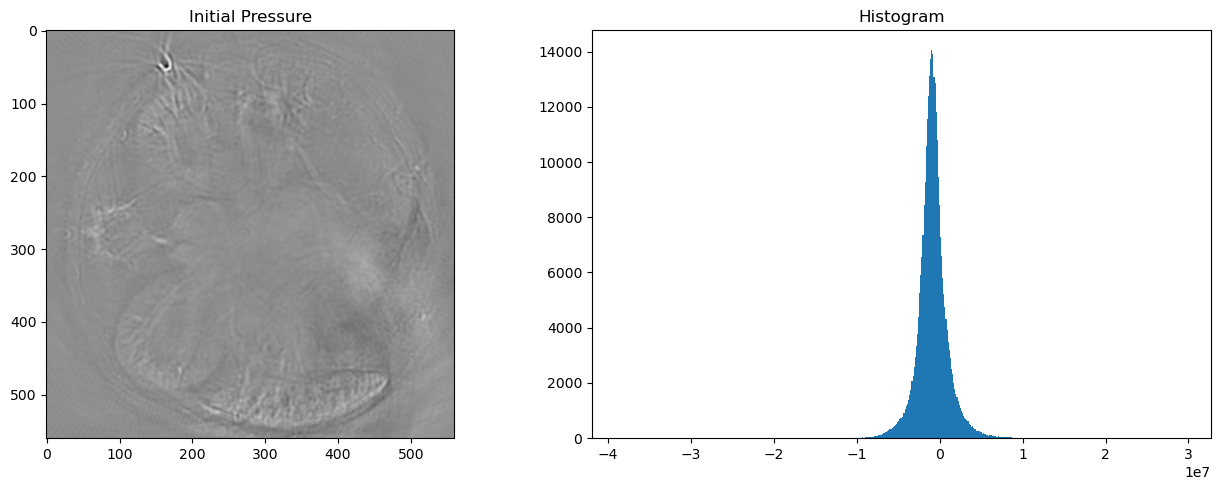

In [126]:
def center(img):
    Nx, Ny = img.shape
    x_sum, y_sum = 0, 0
    for i in range(Nx):
        for j in range(Ny):
            x_sum += i * img[i,j]
            y_sum += j * img[i,j]
    x = int(x_sum / img.sum())
    y = int(y_sum / img.sum())
    return (x, y)

idx = 122
img = mice_full_recon[idx, :, :]
img = cv2.resize(img, (640, 640)) # Resize to (384, 384).
x_c, y_c = center(img)
img = img[x_c-280:x_c+280, y_c-280:y_c+280]
print(img.shape)


fig = plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('Initial Pressure')

plt.subplot(1,2,2)
plt.hist(img.flatten(), bins=512)
plt.title('Histogram')
plt.tight_layout()

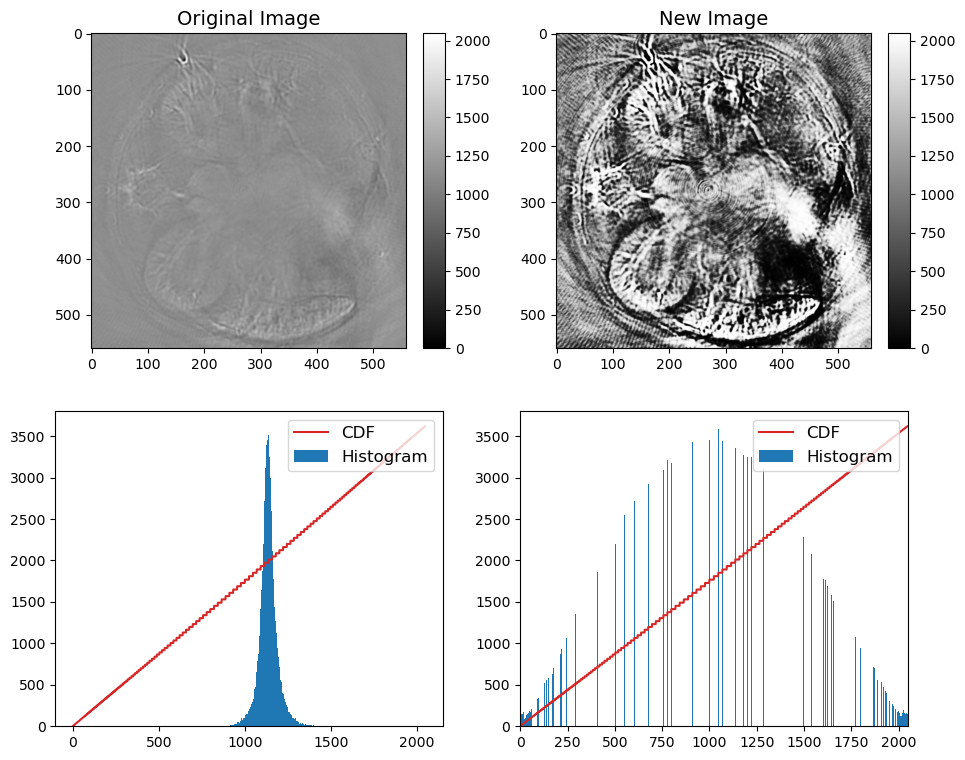

In [127]:
def equalize_histogram(img, bins=1024, restore_mag=True, visualize=False):
    """_summary_

    Args:
        img (_type_): _description_
        bins (int, optional): _description_. Defaults to 1024.
        visualize (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    max, min = img.max(), img.min()
    img = (img - img.min()) / (img.max() - img.min())
    img = ((bins-1) * img).astype(np.uint16)
    hist, _ = np.histogram(img.flatten(), bins=bins)
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()
    
    cdf_m = np.ma.masked_equal(cdf,0).data
    cdf_m = (cdf_m - cdf_m.min()) * (bins-1) / (cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m, 0).astype(np.uint16)
    img_new = cdf[img]
    
    hist, _ = np.histogram(img_new.flatten(), bins=bins, range=[0,bins])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()
    
    if visualize:
        fig = plt.figure(figsize=(11,9))
        ax1 = plt.subplot(2,2,1)
        plt.imshow(img, cmap='gray')
        plt.title('Original Image', fontsize=14)
        cax1 = fig.add_axes([ax1.get_position().x1+0.015, ax1.get_position().y0, 0.02, ax1.get_position().height])
        cb = plt.colorbar(cax=cax1)
        
        ax2 = plt.subplot(2,2,2)
        plt.imshow(img_new, cmap='gray')
        plt.title('New Image', fontsize=14)
        cax2 = fig.add_axes([ax2.get_position().x1+0.015, ax2.get_position().y0, 0.02, ax2.get_position().height])
        cb = plt.colorbar(cax=cax2)
        
        plt.subplot(2,2,3)
        plt.plot(cdf_normalized, color='tab:red')
        plt.hist(img.flatten(), color='tab:blue', bins=bins)
        plt.legend(('CDF', 'Histogram'), loc='upper right', fontsize=12)
        
        plt.subplot(2,2,4)
        plt.plot(cdf_normalized, color='tab:red')
        plt.hist(img_new.flatten(), bins, [0,bins], color='tab:blue')
        plt.xlim([0,bins])
        plt.legend(('CDF', 'Histogram'), loc='upper right', fontsize=12)
        
    if restore_mag:
        img_new = img_new / img_new.max() * (max - min) + min
        
    return img_new

img_new = equalize_histogram(img, bins=2048, restore_mag=True, visualize=True)

In [128]:
# Define the smoothing and sharpening kernel.
def gaussian_kernel(sigma, size):
    function = lambda x,y: np.exp(-((x-(size-1)/2)**2 + (y-(size-1)/2)**2) / (2*(sigma**2)))
    kernel = np.fromfunction(function, (size, size))
    return kernel / np.sum(kernel)

gaussian = gaussian_kernel(1.8, 5)
average = np.ones((5,5)) / 25
sobelx = np.array([[-1,-2,-1], [0,0,0], [1,2,1]])
sobely = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
laplacian = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])

In [129]:
# Apply the sharpening kernel.
def sharpen_img(img, grad_x, grad_y, grad_2, alpha=0.01, beta=0.8):
    
    edge1x = cv2.filter2D(img, -1, grad_x)
    edge1y = cv2.filter2D(img, -1, grad_y)
    edge1 = np.sqrt(edge1x**2 + edge1y**2)
    edge2 = cv2.filter2D(img, -1, grad_2)
    edge = alpha * edge1 + beta * edge2
    return edge
    
def smooth_img(img, kernel):
    return cv2.filter2D(img, -1, kernel)
    
alpha, beta = 0.08, 0.8
edge = sharpen_img(img, sobelx, sobely, laplacian, alpha, beta)
smoothed = smooth_img((3*img+1*img_new)/4, gaussian)
# smoothed = (2*img+1*img_new)/3

IP_img = smoothed + edge

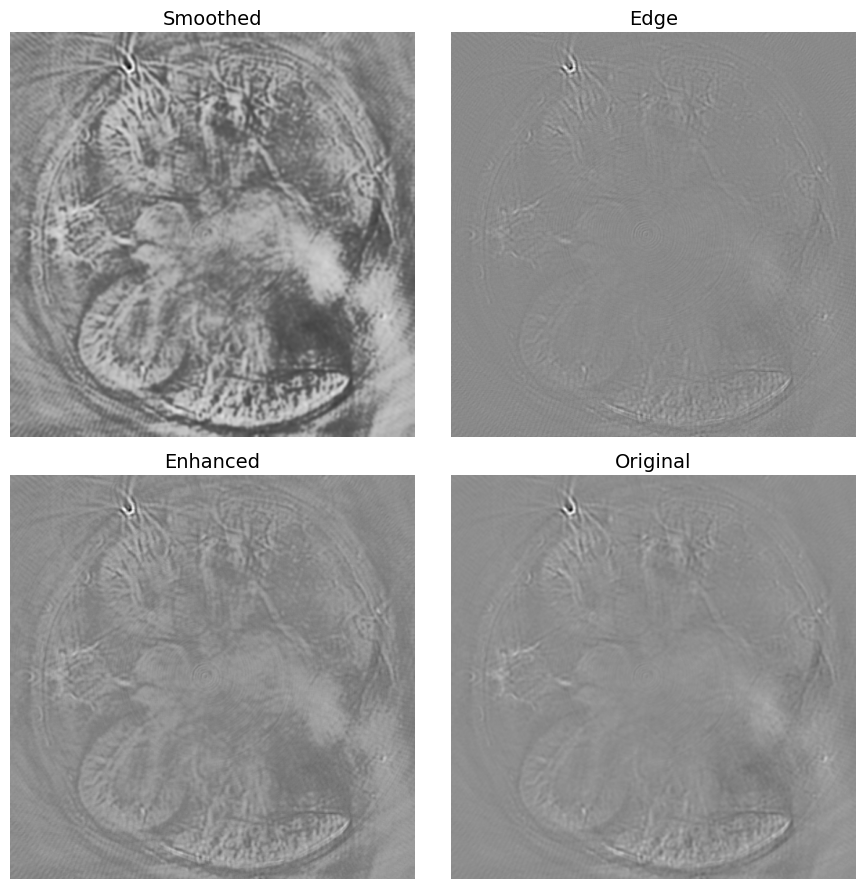

In [130]:
fig = plt.figure(figsize=(9,9))
plt.subplot(2,2,1)
plt.imshow(smoothed, cmap='gray')
plt.title('Smoothed', fontsize=14)
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(edge, cmap='gray')
plt.title('Edge', fontsize=14)
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(IP_img, cmap='gray')
plt.title('Enhanced', fontsize=14)
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(img, cmap='gray')
plt.title('Original', fontsize=14)
plt.axis('off')
plt.tight_layout()

In [131]:
assert False

AssertionError: 

Pad the image to the size of the computaional grid.

In [ ]:
pad_x, pad_y = 2544, 2544 # 2024, 2024
IP_pad = np.zeros((pad_x, pad_y))
pad_start, pad_end = (pad_x-IP_img.shape[0])//2, (pad_x+IP_img.shape[1])//2
IP_pad[pad_start:pad_end, pad_start:pad_end] = IP_img
np.save('data/IP_pad.npy', IP_pad)

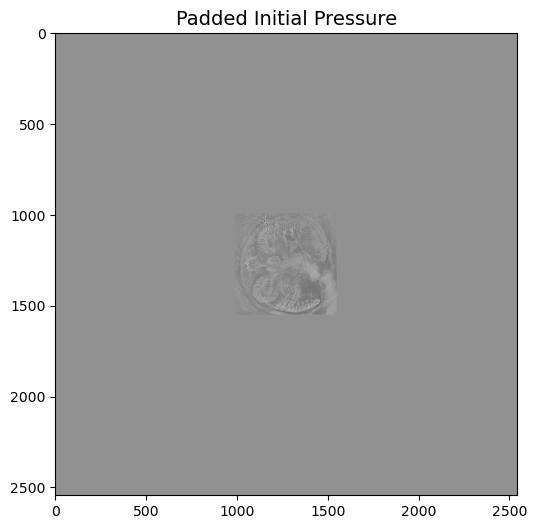

In [ ]:
plt.figure(figsize=(6,6))
plt.title('Padded Initial Pressure', fontsize=14)
plt.imshow(IP_pad, cmap='gray')

In [ ]:
pathname = gettempdir()

PML_size = 8                                # Size of the PML in grid points.
Nx, Ny = IP_pad.shape
R_ring = 0.05                               # Radius of the ring array [m].
dx, dy = 4.e-5, 4.e-5                       # Grid point spacing in the y direction [m].
T_sample = 1/80e6                           # Sample time step [s].

N_transducer = 512                          # Number of transducers in ring array.
center_pos = [0, 0]
arc_angle = 2 * np.pi
kgrid = kWaveGrid([Nx, Ny], [dx, dy])

Define SoS distribution.

(19.5, 35.5)

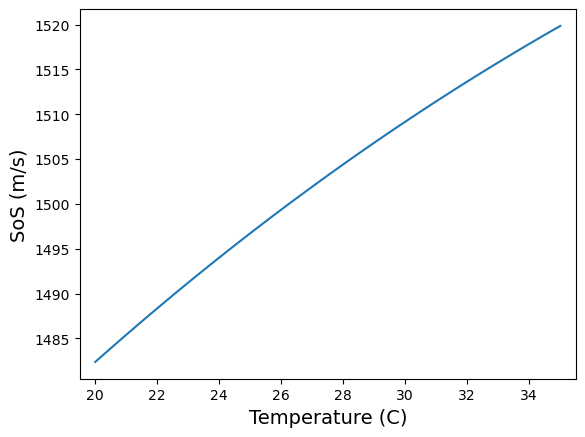

In [ ]:
def get_water_SoS(t):
    """Calculate the speed of sound of water at temperature `t` in Celsius."""
    a = [1.402385e3, 5.038813, -5.799136e-2, 3.287156e-4, -1.398845e-6, 2.787860e-9]
    SoS = 0
    for i in range(len(a)):
        SoS += a[i] * t**i
    return SoS

ts = np.linspace(20, 35, 100)
vs = [get_water_SoS(t) for t in ts]
plt.plot(ts, vs)
plt.xlabel('Temperature (C)', fontsize=14)
plt.ylabel('SoS (m/s)', fontsize=14)
plt.xlim(19.5, 35.5)

In [ ]:
R, R1 = 9.2e-3, 4.5e-3          # Radius of circles in SoS distribution. [m]
offset = (1.2e-3, 9e-4)           # Offset of circle in SoS distribution.[m]
v0, v1, v2 = get_water_SoS(28), 1600, 1650             # SoS of the two circles. [m/s]
SoS_das = 1515.0 # SoS used in DAS when medium is not uniform. [m/s]

XX, YY = np.meshgrid(kgrid.x_vec.copy(), kgrid.y_vec.copy())
SoS = np.ones((Ny, Nx)) * v0
SoS[XX**2 + YY**2 < R**2] = v1
SoS[(XX + offset[0])**2 + (YY + offset[1])**2 < R1**2] = v2
rou = 1000 # Density.
medium = kWaveMedium(sound_speed=SoS, sound_speed_ref=v0, density=rou)

Draw the SoS distribution and the size of image.

<Figure size 700x700 with 0 Axes>

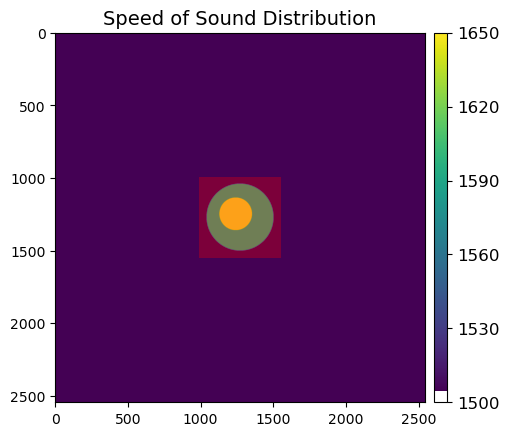

In [ ]:
plt.figure(figsize=(7,7))
fig, ax = plt.subplots()
plt.title('Speed of Sound Distribution', fontsize=14)
plt.imshow(SoS)
left, bottom, width, height = (pad_x//2-280, pad_y//2-280, 560, 560)
image = mpatches.Rectangle((left,bottom), width, height, alpha=0.3, facecolor="red")
plt.gca().add_patch(image) # Show the size of image.
cax = fig.add_axes([ax.get_position().x1+0.015, ax.get_position().y0, 0.02, ax.get_position().height])
cb = plt.colorbar(cax=cax)
cb.ax.tick_params(labelsize=13)
cb.ax.set_yticks([1500, 1530, 1560, 1590, 1620, 1650])
plt.tick_params(labelsize=12)
# plt.savefig('../figures/SoS.jpg', bbox_inches='tight')

### K-wave Forward Simulation

In [ ]:
# source = kSource()
# source.p0 = IP_pad

# # Smooth the initial pressure distribution and restore the magnitude.
# source.p0 = smooth(source.p0, True)

# cart_sensor_mask = makeCartCircle(R_ring, N_transducer, center_pos, arc_angle)
# sensor = kSensor(cart_sensor_mask) # Assign to sensor structure.

# # Create the time array.
# kgrid.makeTime(medium.sound_speed)
# kgrid.setTime(4000, T_sample) 

# # Set the input arguements: force the PML to be outside the computational grid switch off p0 smoothing within kspaceFirstOrder2D.
# input_args = {
#     'PMLInside': False,
#     'PMLSize': PML_size,
#     'Smooth': False,
#     'SaveToDisk': os.path.join(pathname, f'example_input.h5'),
#     'SaveToDiskExit': False,
# }

# # Run the simulation.
# sensor_data = kspaceFirstOrder2DC(**{
#     'medium': medium,
#     'kgrid': kgrid,
#     'source': source,
#     'sensor': sensor,
#     **input_args
# })

# print(sensor_data.shape)

Downsample the sensor data.

In [ ]:
# sensor_data = sensor_data[:, ::2]

In [ ]:
def reorder_binary_sensor_data(sensor_data, sensor, kgrid, PML_size):

    x_sensor = kgrid.x[sensor.mask[PML_size:-PML_size,PML_size:-PML_size] == 1]
    y_sensor = kgrid.y[sensor.mask[PML_size:-PML_size,PML_size:-PML_size] == 1]
    
    angle = np.arctan2(-x_sensor, -y_sensor)
    angle[angle < 0] = 2 * np.pi + angle[angle < 0]
    reorder_index = np.argsort(angle)
    
    return sensor_data[reorder_index]

# sensor_data = reorder_binary_sensor_data(sensor_data, sensor, kgrid, PML_size)

Apply transducer effect.

In [ ]:
def transducer_response(sensor_data):
    sensor_data = np.append(sensor_data, np.zeros((sensor_data.shape[0],1)), axis=1)
    return -2 * (sensor_data[:,1:] - sensor_data[:,:-1])

# sinogram = transducer_response(sensor_data)

In [ ]:
# np.save(os.path.join("./data", f"sinogram_simulation.npy"), sinogram) # Save sinogram.

In [ ]:
sinogram = np.load(os.path.join("./data", f"sinogram_simulation.npy")) # Save sinogram.

/tmp/ipykernel_844302/3326551966.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,1,1)


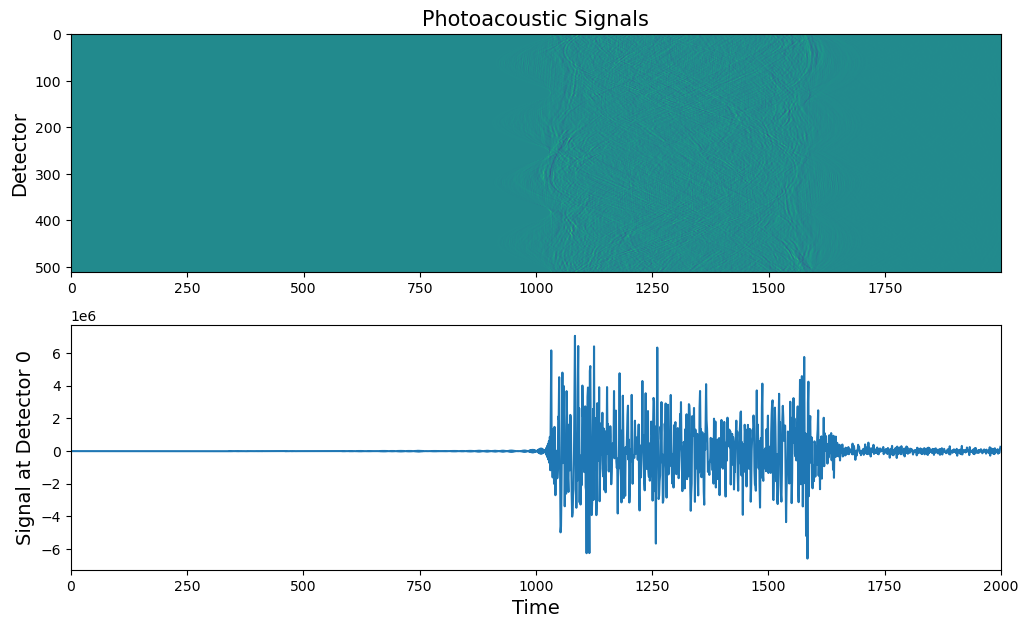

In [ ]:
fig, plt.subplots(figsize=(12,7))
plt.subplot(2,1,1)
plt.title('Photoacoustic Signals', fontsize=15)
plt.ylabel('Detector', fontsize=14)
plt.imshow(sinogram)

ax = plt.subplot(2,1,2)
plt.plot(sinogram[0,:])
plt.xlabel('Time', fontsize=14)
plt.ylabel('Signal at Detector 0', fontsize=14)
plt.xlim(0, 2000)
plt.show()
# plt.savefig('../figures/sinogram.jpg', bbox_inches='tight')

(1, 2000)


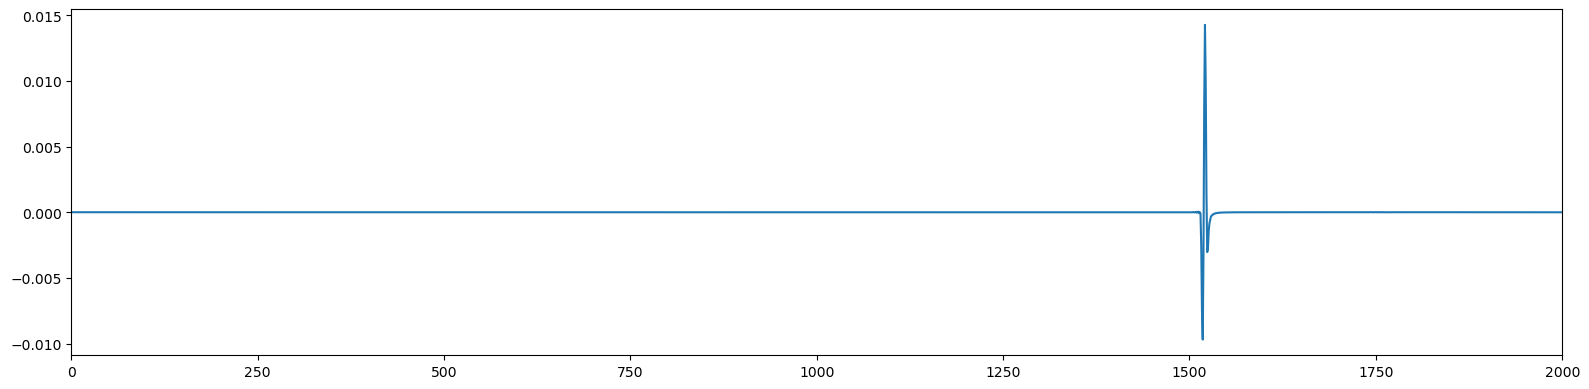

In [ ]:
EIR_data = h5py.File('data/EIR_KWAVE.mat')
EIR = np.array(EIR_data['ht'])
EIR = np.append(EIR, 0)
EIR = -2 * (EIR[1:] - EIR[:-1])
EIR = np.expand_dims(EIR, axis=0)
print(EIR.shape)

time = np.linspace(0, 2000, 2000)
plt.figure(figsize=(16,4))
plt.plot(time, np.squeeze(EIR[:2000]))
plt.xlim(0, 2000)
plt.tight_layout()

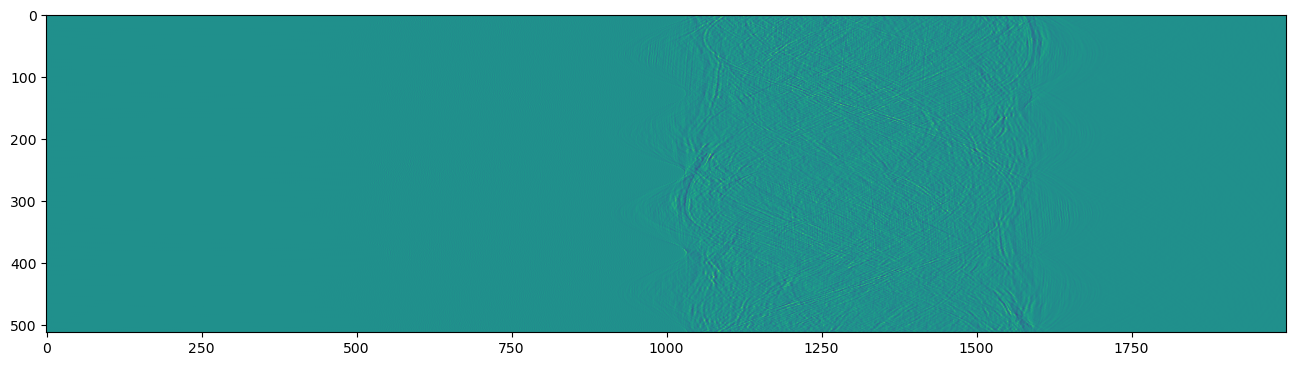

In [ ]:
def deconvolve_sinogram(sinogram, EIR, t0):
    delta = np.zeros_like(EIR)
    delta[0, t0] = 1
    
    delta_ft = fft(delta, axis=1)
    EIR_ft = fft(EIR, axis=1)
    Sinogram_ft = fft(sinogram, axis=1)
    
    Sinogram_ft *= np.exp(1j * (np.angle(delta_ft) - np.angle(EIR_ft)))
    
    sinogram_deconv = np.real(ifft(Sinogram_ft, axis=1))
    return sinogram_deconv

t0 = np.argmax(EIR)    
sinogram_deconv = deconvolve_sinogram(sinogram, EIR, t0)
plt.subplots(figsize=(16,5))
plt.imshow(sinogram_deconv)
plt.show()

### DAS Reconstruction

In [ ]:
@numba.jit(nopython=True) 
def delay_and_sum(R_ring, T_sample, V_sound, Sinogram, ImageX, ImageY, d_delay=0):
    """Generate a 2D Delay And Sum reconstructed PACT image of ring transducer array. This function is accelerated by `numba.jit` on a GPU.

    Args:
        R_ring (`float`): The R_ring [m] of the ring transducer array.
        T_sample (`float`): Sample time interval [s] of the signals.
        V_sound (`float`): The sound speed [m/s] used for Delay And Sum reconstruction.
        Sinogram (`numpy.ndarray`): A 2D array and each column of it is the signal recievde by one transducer. The nummber of transducers should be the number of columns. The transducers should be evenly distributed on a circle in counterclockwise arrangement and the first column correspond to the transducer in the dirrection `2pi/N` in the first quartile. The first sample should be at time 0 when the photoacoustic effect happens.
        ImageX (`numpy.ndarray`): The vector [m] defining the x coordinates of the grid points on which the reconstruction is done. The values in the vector should be unifromly-spaced in ascending order. The origin of the cartesian coordinate system is the center of the ring array.
        ImageY (`numpy.ndarray`): The vector [m] defining the y coordinates of the grid points on which the reconstruction is done. The values in the vector should be unifromly-spaced in ascending order. The origin of the cartesian coordinate system is the center of the ring array.
        d_delay (`float`): The delay distance [m] of the signals used in DAS. The default value is 0.

    Returns:
        `numpy.ndarray`: A 2D array of size `(len(ImageY), len(ImageX))`. `Image[t, s]` is the reconstructed photoacoustic amplitude at the grid point `(ImageX[s], ImageY[t])`.
    """

    N_transducer = Sinogram.shape[0]
    Image = np.zeros((len(ImageX), len(ImageY)))
    delta_angle = 2*np.pi / N_transducer
    angle_transducer = delta_angle * (np.arange(N_transducer,) + 1)

    x_transducer = R_ring * np.sin(angle_transducer - np.pi)
    y_transducer = R_ring * np.cos(angle_transducer - np.pi)
    
    related_data = np.zeros((N_transducer,))
    
    for s in range(len(ImageX)):
        for t in range(len(ImageY)):
            distance_to_transducer = np.sqrt((x_transducer - ImageX[s])**2 + (y_transducer - ImageY[t])**2) - d_delay
            for k in range(N_transducer):
                id = floor(distance_to_transducer[k]/(V_sound * T_sample))
                if id > Sinogram.shape[1] or id < 0:
                    related_data[k] = 0
                else:
                    related_data[k] = Sinogram[k, id]
            Image[t, s] = related_data.mean()
    return Image

In [ ]:
def get_delays(R, v0, v1, n_delays, mode='linear'):
    if mode == 'linear':
        return np.linspace(0, (1-v0/v1) * R, n_delays)
    elif mode == 'quadric':
        return (1-v0/v1) * R * np.sqrt(np.linspace(0,1,n_delays))
    else:
        raise NotImplementedError
    
n_delays = 8
delays = get_delays(R, v0, v1, n_delays, 'linear')
print(delays)

recons = []
for d_delay in delays:
    recon = delay_and_sum(R_ring,
                          1/40e6,
                          v0,
                          sinogram_deconv,
                          kgrid.x_vec[pad_start:pad_end],
                          kgrid.y_vec[pad_start:pad_end],
                          d_delay=d_delay)
    recons.append(recon)
obs_imgs = np.array(recons)

[0.00000000e+00 7.85198033e-05 1.57039607e-04 2.35559410e-04
 3.14079213e-04 3.92599017e-04 4.71118820e-04 5.49638623e-04]


Text(0.5, 1.0, 'Histogram of Gold Standard')

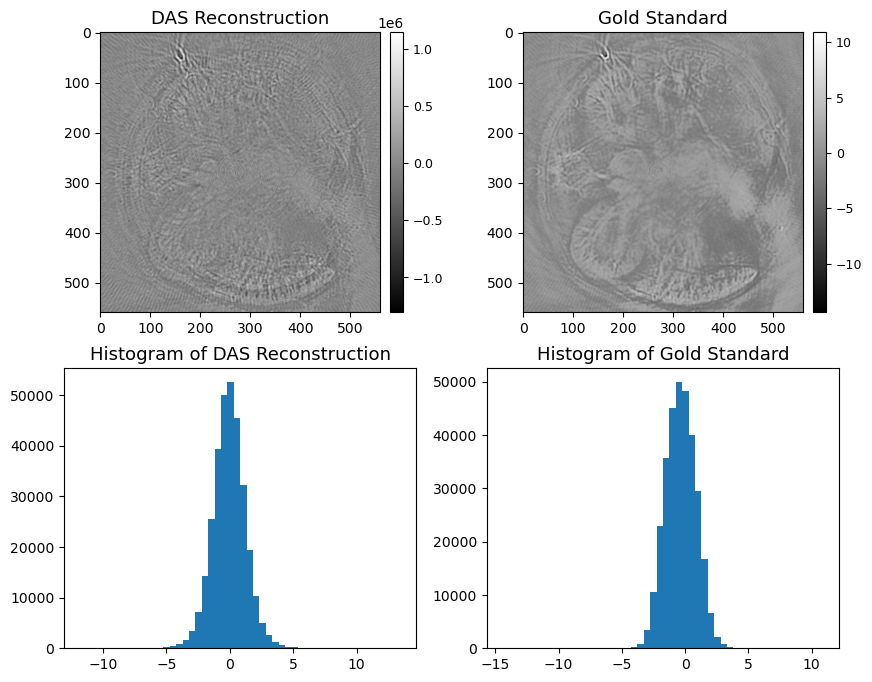

In [ ]:
fig = plt.figure(figsize=(10,8))
vmax = np.max([recons[3].max(), IP_img.max()])
vmin = np.min([recons[3].min(), IP_img.min()])
norm = matplotlib.colors.Normalize(vmax=vmax, vmin=vmin)

recons[3] = recons[3] / np.abs(recons[3]).mean()
ax1 = plt.subplot(2,2,1)
plt.imshow(recons[0], cmap='gray')
plt.title('DAS Reconstruction', fontsize=13)
cax1 = fig.add_axes([ax1.get_position().x1+0.01, ax1.get_position().y0, 0.013, ax1.get_position().height])
cb1 = plt.colorbar(cax=cax1)
cb1.ax.tick_params(labelsize=9)
# cb1.ax.set_yticks([-0.2, -0.1, 0.0, 0.1])

plt.subplot(2,2,3)
plt.hist((recons[3]).ravel(), bins=50)
plt.title('Histogram of DAS Reconstruction', fontsize=13)
  
IP_img = IP_img / np.abs(IP_img).mean()
ax2 = plt.subplot(2,2,2)
plt.imshow(IP_img, cmap='gray')
plt.title('Gold Standard', fontsize=13)
cax2 = fig.add_axes([ax2.get_position().x1+0.01, ax2.get_position().y0, 0.013, ax2.get_position().height])
cb2 = plt.colorbar(cax=cax2)
cb2.ax.tick_params(labelsize=9)


plt.subplot(2,2,4)
plt.hist(IP_img.ravel(), bins=50)
plt.title('Histogram of Gold Standard', fontsize=13)

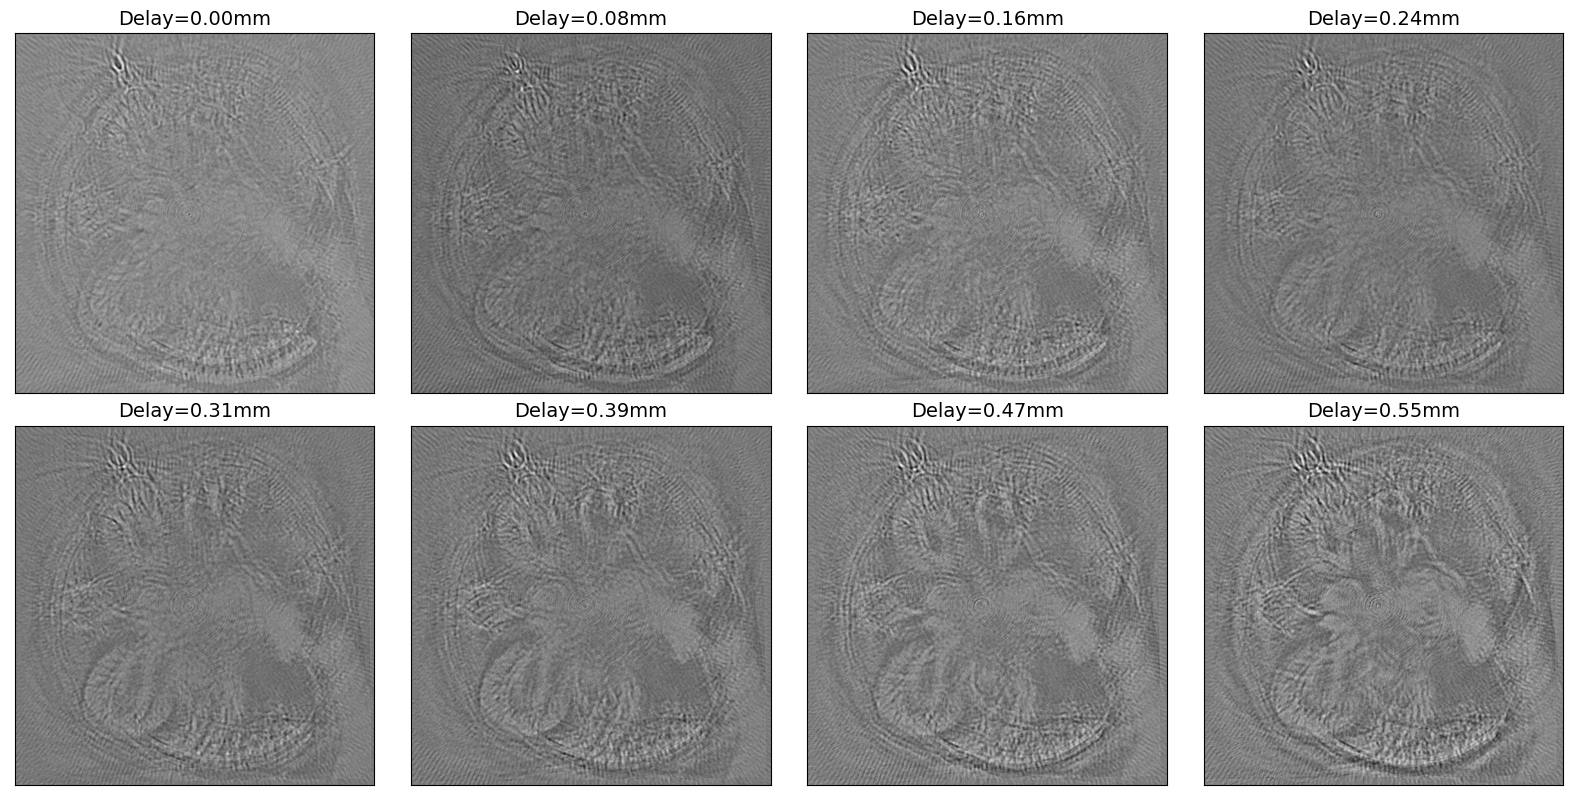

In [ ]:
plt.figure(figsize=(16, 8))
for idx, d_delay in enumerate(delays):
    ax1 = plt.subplot(2,4,idx+1)
    plt.imshow(recons[idx], cmap='gray')
    plt.title('Delay={:.2f}mm'.format(d_delay*1e3), fontsize=14)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

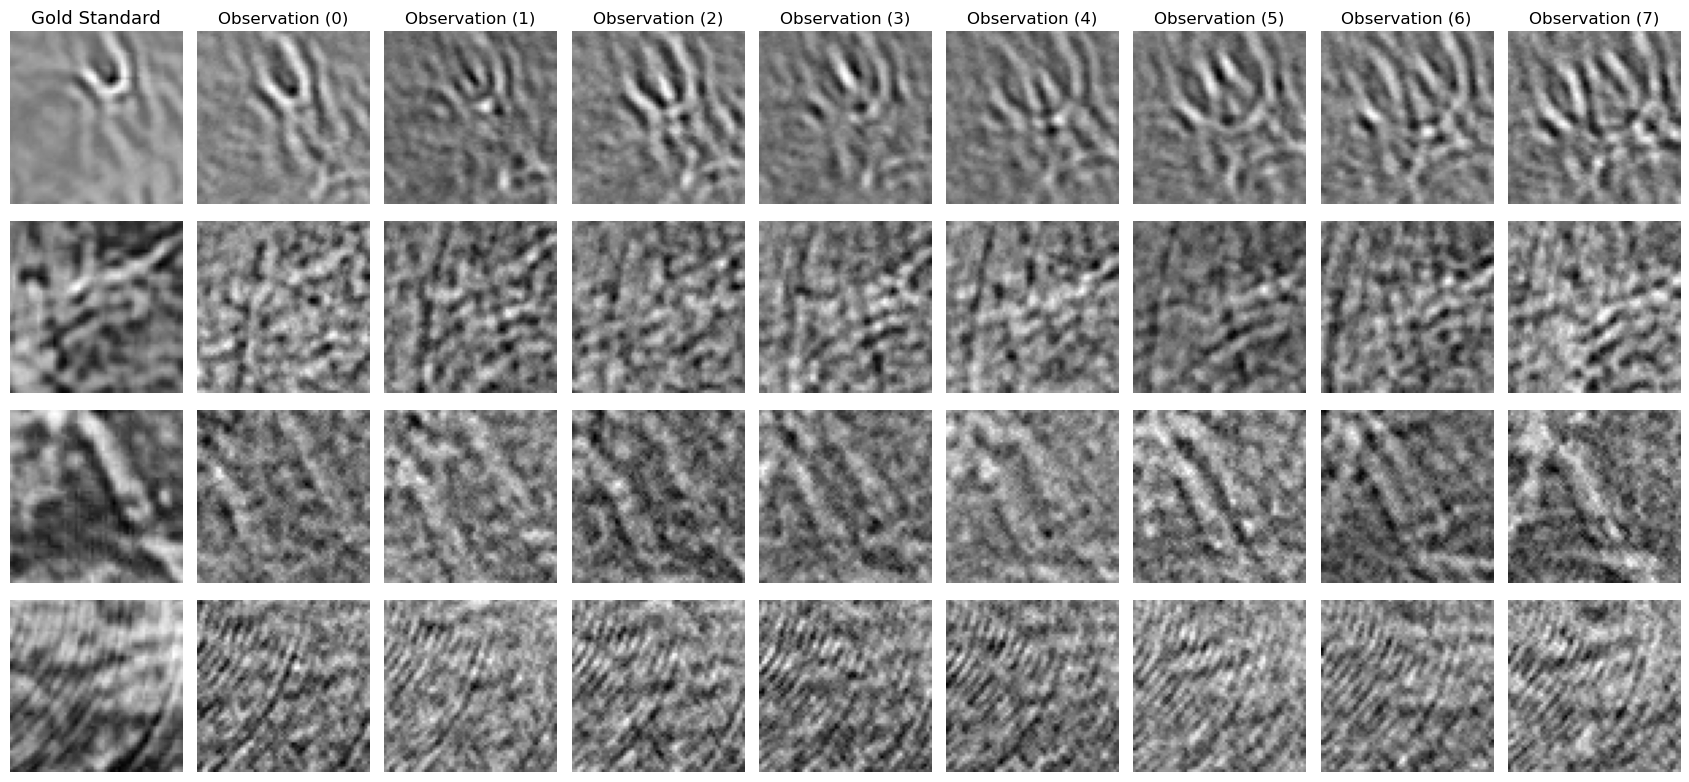

In [ ]:
i, j = 4, 3
plt.figure(figsize=(17,8))
for idx, (i,j) in enumerate([(1,4), (7,2), (5,10), (9,10)]):
    plt.subplot(4,9,idx*9+1)
    plt.imshow(IP_img[32*i:32*i+64, 32*j:32*j+64], cmap='gray')
    plt.axis('off')
    if idx == 0:
        plt.title('Gold Standard', fontsize=13)
    for k in range(8):
        plt.subplot(4,9,idx*9+k+2)
        plt.imshow(obs_imgs[k, 32*i:32*i+64, 32*j:32*j+64], cmap='gray')
        plt.axis('off')
        if idx == 0:
            plt.title(f'Observation ({k})')
plt.tight_layout()

### Image with no SoS Distribution

In [ ]:
# SoS = np.ones((Ny, Nx)) * 1500
# rou = 1000  # Density.
# medium = kWaveMedium(sound_speed=SoS, sound_speed_ref=SoS_das, density=rou)

In [ ]:
# source = kSource()
# source.p0 = IP_pad

# # Smooth the initial pressure distribution and restore the magnitude.
# source.p0 = smooth(source.p0, True)

# cart_sensor_mask = makeCartCircle(R_ring, N_transducer, center_pos, arc_angle)
# sensor = kSensor(cart_sensor_mask) # Assign to sensor structure.

# # Create the time array.
# kgrid.makeTime(medium.sound_speed)
# kgrid.setTime(4000, T_sample) ##

# # Set the input arguements: force the PML to be outside the computational grid switch off p0 smoothing within kspaceFirstOrder2D.
# input_args = {
#     'PMLInside': False,
#     'PMLSize': PML_size,
#     'Smooth': False,
#     'SaveToDisk': os.path.join(pathname, f'example_input.h5'),
#     'SaveToDiskExit': False, 
# }

# # Run the simulation.
# sensor_data_clean = kspaceFirstOrder2DC(**{
#     'medium': medium,
#     'kgrid': kgrid,
#     'source': source,
#     'sensor': sensor,
#     # 'reorder_data': True,
#     **input_args
# })

In [ ]:
# sensor_data_clean = sensor_data_clean[:, ::2]

In [ ]:
# sensor_data_clean = reorder_binary_sensor_data(sensor_data_clean, sensor, kgrid, PML_size)
# sensor_data_clean = transducer_response(sensor_data_clean)

In [ ]:
# fig, ax = plt.subplots(figsize=(12,4))
# plt.title('Photoacoustic Signals', fontsize=15)
# plt.xlabel('Time', fontsize=14)
# plt.ylabel('Detector', fontsize=14)
# plt.imshow(sensor_data_clean)
# cax = fig.add_axes([ax.get_position().x1+0.015, ax.get_position().y0, 0.02, ax.get_position().height])
# plt.colorbar(cax=cax)

In [ ]:
# recon_clean = delay_and_sum(R_ring,
#                             1/40e6,
#                             medium.sound_speed_ref,
#                             sensor_data_clean,
#                             kgrid.x_vec[pad_start:pad_end],
#                             kgrid.y_vec[pad_start:pad_end],
#                             d_delay=0)

In [ ]:
# fig = plt.figure(figsize=(15,9.5))

# ax1 = plt.subplot(2,3,1)
# plt.imshow(recons[3], cmap='gray')
# plt.title('DAS Reconstruction', fontsize=14)
# plt.ylabel('Image', fontsize=14)
# # cax1 = fig.add_axes([ax1.get_position().x1+0.008, ax1.get_position().y0, 0.012, ax1.get_position().height])
# # cb1 = plt.colorbar(cax=cax1)
# # cb1.ax.tick_params(labelsize=9)
# # cb1.ax.set_yticks([-0.2, -0.1, 0.0,/ 0.1])

# plt.subplot(2,3,4)
# plt.hist(recons[3].ravel(), bins=50)
# # plt.title('Histogram of DAS Reconstruction', fontsize=13)
# plt.ylabel('Histogram', fontsize=14)

# ax2 = plt.subplot(2,3,2)
# plt.imshow(recon_clean, cmap='gray')
# plt.title('DAS Reconstruction (No Distortion)', fontsize=14)
# # cax2 = fig.add_axes([ax2.get_position().x1+0.008, ax2.get_position().y0, 0.012, ax2.get_position().height])
# # cb2 = plt.colorbar(cax=cax2)
# # cb2.ax.tick_params(labelsize=9)
# # cb2.ax.set_yticks([-0.2, -0.1, 0.0, 0.1])

# plt.subplot(2,3,5)
# plt.hist(recon_clean.ravel(), bins=50)
# # plt.title('Histogram of DAS Reconstruction', fontsize=13)

# ax3 = plt.subplot(2,3,3)
# plt.imshow(IP_img, cmap='gray')
# plt.title('Gold Standard', fontsize=14)
# # cax3 = fig.add_axes([ax3.get_position().x1+0.008, ax3.get_position().y0, 0.012, ax3.get_position().height])
# # cb3 = plt.colorbar(cax=cax3)
# # cb3.ax.tick_params(labelsize=9)

# plt.subplot(2,3,6)
# plt.hist(IP_img.ravel(), bins=50)
# plt.title('Histogram of Gold Standard', fontsize=13)

# # plt.savefig('../figures/histogram.jpg', bbox_inches='tight')
# # plt.imsave('../figures/gt.jpg', gt)
# # plt.imsave('../figures/obs.jpg', recons[3])
# # plt.imsave('../figures/rec.jpg', recon_clean)

In [ ]:
# print(recon[3].mean(), recon_clean.mean(), IP_img.mean())
# print(np.abs(recon[3]).mean(), np.abs(recon_clean).mean(), np.abs(IP_img).mean())

Calculate PSF for each delay.

In [ ]:
# psfs = []
# for recon in recons:
#     # psf = fftshift(ifft2(fft2(recon) / fft2(recon_clean))).real
#     psf = fftshift(ifft2(fft2(recon) / fft2(IP_img))).real
#     psfs.append(psf)

In [ ]:
# i, j = 4, 3
# plt.figure(figsize=(16,4))
# for k in range(8):
#     size=64
#     plt.subplot(2,8,k+1)
#     plt.imshow(obs_imgs[k, 32*i:32*i+size, 32*j:32*j+size], cmap='gray')
#     plt.xticks([])
#     plt.yticks([])
#     plt.title(f'Observation ({k})')
    
#     plt.subplot(2,8,k+9)
#     psf = fftshift(ifft2(fft2(obs_imgs[k, 32*i:32*i+size, 32*j:32*j+size]) / fft2(recon_clean[32*i:32*i+size, 32*j:32*j+size]))).real
#     plt.imshow(psf, cmap='gray')
#     plt.xticks([])
#     plt.yticks([])
#     plt.title(f'PSF ({k})')